In [4]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import glob, os

# Challenge: Topic extraction on new data

Take the well-known [20 newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset and use each of the methods on it.  Your goal is to determine which method, if any, best reproduces the topics represented by the newsgroups.  Write up a report where you evaluate each method in light of the 'ground truth'- the known source of each newsgroup post.  Which works best, and why do you think this is the case?

# Prepare the data

In [19]:
# Get the data and combine it into one csv
numberoftextfiles=0
NewsCat=[]
Content=[]
Title=[]
Length=[]

for folder in os.listdir('20news-bydate.tar/20news-bydate-train'):
    #print(folder)
    pathtofolder='20news-bydate.tar/20news-bydate-train/'+folder+'/*'
    for file in glob.glob(pathtofolder):
        #print(file)
        try:
            file_object = open(file, 'r') 
            text=file_object.read()
            Content.append(text)
            Length.append(len(text))
            Title.append(file)
            NewsCat.append(folder)
            numberoftextfiles=numberoftextfiles+1
        except:
            pass
    
print('In total there are',numberoftextfiles,'files to be analysed.')   
print('The longest document has a length of',max(Length),'words.')  
print('The shortedt document has a length of',min(Length),'words.')  
print(len(Content))
print(len(NewsCat))
print(len(Length))
print(len(Title))

In total there are 11314 files to be analysed.
The longest document has a length of 75154 words.
The shortedt document has a length of 125 words.
11314
11314
11314
11314


In [22]:
# Safe information in a df
df=pd.DataFrame(columns=['NewsCat','Title','Length','Content'])
df['NewsCat']=NewsCat
df['Title']=Title
df['Length']=Length
df['Content']=Content
df.head()

,NewsCat,Title,Length,Content
0,alt.atheism,20news-bydate.tar/20news-bydate-train/alt.athe...,11891,From: mathew <mathew@mantis.co.uk>\nSubject: A...
1,alt.atheism,20news-bydate.tar/20news-bydate-train/alt.athe...,32056,From: mathew <mathew@mantis.co.uk>\nSubject: A...
2,alt.atheism,20news-bydate.tar/20news-bydate-train/alt.athe...,4092,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...
3,alt.atheism,20news-bydate.tar/20news-bydate-train/alt.athe...,1627,From: mathew <mathew@mantis.co.uk>\nSubject: R...
4,alt.atheism,20news-bydate.tar/20news-bydate-train/alt.athe...,773,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...


In [28]:
# Unique categories
print(len(df.NewsCat.unique()))
df.NewsCat.unique()

20


array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

# Generate a tfidf-matrix for the documents

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating the tf-idf matrix.
#Initiate the vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than 50% of all the paragraphs
                                min_df=4, # only use words that appear at least 4 times
                                stop_words='english', 
                                lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                                use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                                norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                smooth_idf=True, #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                ngram_range=(1, 1) # include 1,1 word combinations
                            )

# Fit the vectorizer using the training set
Content_tfidf=vectorizer.fit_transform(Content)

In [59]:
# Getting the word list.
terms = vectorizer.get_feature_names()
#print(len(terms))
#print(terms[0:10])
# Number of topics, as we have 20 news categories
# But lets first focus on the 6 main categories
ntopics=6

In [60]:
# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1]) # get the number of components/topics
    index= np.repeat(n_topics, n_top_words, axis=0) #(what to repeat, number of repeats, axis along which to repeat)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 5

# Topic extraction
## LSA

In [61]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
Content_lsa = lsa.fit_transform(Content_tfidf)

#print('TFIDF shape:',Content_tfidf.shape)
#print('paras-lsa shape:',Content_lsa.shape)

components_lsa = word_topic(Content_tfidf, Content_lsa, terms)

#print(components_lsa.head(10))

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)     

## LDA

In [62]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

Content_lda = lda.fit_transform(Content_tfidf) 
print('TFIDF shape:',Content_tfidf.shape)
print('paras_lda shape:',Content_lda.shape)

components_lda = word_topic(Content_tfidf, Content_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


TFIDF shape: (11314, 30508)
paras_lda shape: (11314, 6)


## None negative Matrix Factorization

In [63]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
Content_nmf = nmf.fit_transform(Content_tfidf) 

components_nmf = word_topic(Content_tfidf, Content_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

## Comparison of the three extraction methods

### Top words per topic

In [64]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                LSA             LDA             NNMF
0        com 214.68         ax 6.79      windows 4.4
0    article 124.11        com 6.39         com 3.86
0  university 117.9  university 3.8       drive 2.91
0    posting 107.88    article 3.54  university 2.64
0       like 106.91    posting 3.36        card 2.57
Topic 1:
               LSA                LDA            NNMF
1        god 55.04         com 248.95       god 11.54
1      people 32.6     article 142.02       jesus 5.1
1      jesus 25.79  university 133.97     people 3.58
1  christian 17.31         don 121.37      bible 3.26
1      bible 17.05     posting 121.31  christian 2.94
Topic 2:
                LSA              LDA             NNMF
2         key 35.04         com 6.59          key 6.2
2     clipper 28.55  university 3.83     clipper 4.85
2         com 27.63     article 3.73  encryption 4.71
2  encryption 25.53     posting 3.51        chip 4.68
2         chip 25.2        host 3.48        keys 2.76
Topic 3

### Can the 6 main categories be differentiated
![](20NewsgroupsSubcategories.JPG)

In [65]:
# So there are 6 main categories
# Check if these keywords are included in the index
subcategories1=['computer','sport','science','sale','politics','religion']
for word in subcategories1:
    print(word, word in terms)

computer True
sport True
science True
sale True
politics True
religion True


In [80]:
components_lsa.loc['computer'].append(components_lda.loc['computer'].append(components_nmf.loc['computer']))

0    59.648536
1   -19.509764
2    -5.596580
3     2.794230
4     7.167355
5    -3.296106
0     1.813655
1    70.773155
2     1.923853
3     1.741812
4     1.772023
5     1.748447
0     1.910290
1     0.392870
2     0.755968
3     0.618246
4     1.289660
5     1.409120
Name: computer, dtype: float64

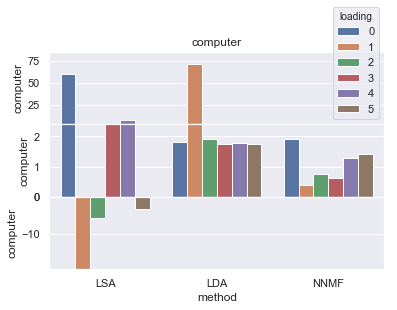

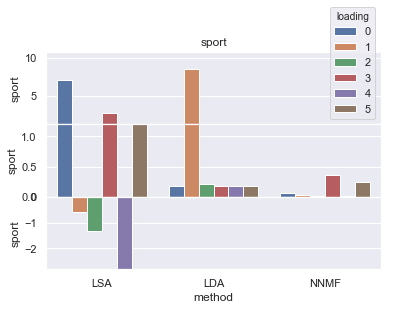

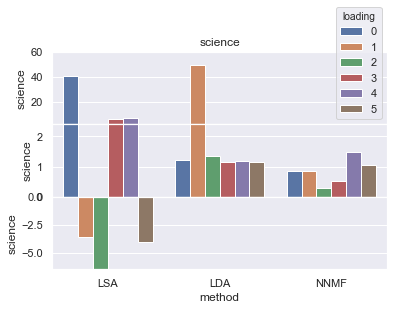

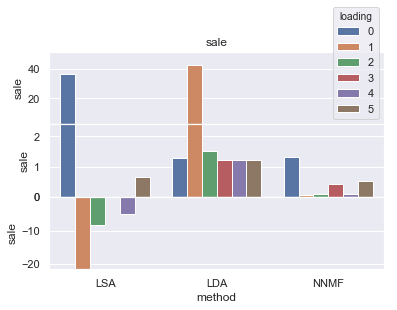

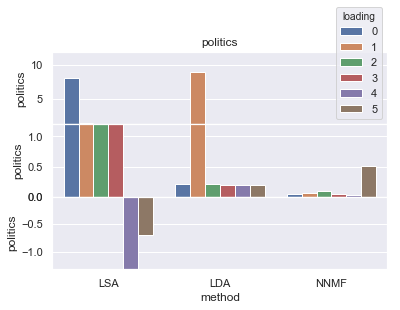

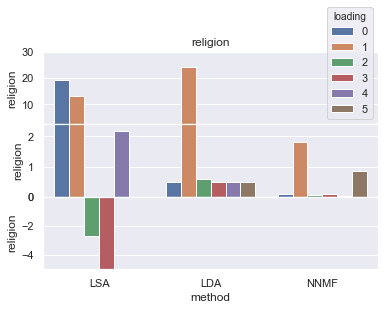

In [74]:
import math
# Let's plot the data, to get a better overview
# Each Target words should describe each category
# let's try this first with the subcategories
subcategories1=['computer','sport','science','sale','politics','religion']

# Storing the loadings.
wordloadings1=pd.DataFrame(columns=subcategories1)

# For each word, extracting and string the loadings for each method.
for word in subcategories1:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings1[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings1['method']=np.repeat(['LSA','LDA','NNMF'], 6, axis=0)
wordloadings1['loading']=[0,1,2,3,4,5]*3

sns.set(style="darkgrid")

for word in subcategories1:
    #Make two plots each, so that the loading in  the NNMF are also visible
    f, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, sharex=True)
    
    # Determine the maxY values for the split plots
    # Max of the top graph
    maxY1=math.ceil(wordloadings1[word].max())+math.ceil(wordloadings1[word].max())/5
    # Max of the lower graph is max of the NNMF feature
    maxNNMF=wordloadings1[word][wordloadings1.method=='NNMF'].max()
    maxY2=math.ceil(maxNNMF)+math.ceil(maxNNMF)/5
    
    minY3=wordloadings1[word].min()
    
    # Top graph
    ax = sns.barplot(data=wordloadings1,x="method", y=word, hue="loading", ax=ax1)
    #ax.legend().set_visible(False)  
    ax1.set_ylim(maxY2, maxY1)
    ax1.set_title(word)
    
    ax = sns.barplot(data=wordloadings1,x="method", y=word, hue="loading", ax=ax2)
    ax.legend().set_visible(False)
    ax2.set_ylim(0, maxY2)
    
    ax = sns.barplot(data=wordloadings1,x="method", y=word, hue="loading", ax=ax3)
    ax.legend().set_visible(False)
    ax3.set_ylim(minY3, 0)

    plt.subplots_adjust(wspace=0, hspace=0)


# Results

Initially, I tried to differentiate all 20 categories, that was a little too ambitious. With the 6 subcategories, however, the results don't look that bad at least for the NNMF.
LSA and LDA, can not differentiate those 6 keywords into different topics, NNMF does. For each keyword, another is loading is the top hit.<br>
NNMF wins because the matrix is the most sparse, meaning it links the fewest words to a topic. 